# Process File Of Aligned Transcripts And Compute Stats On It

### Process The Aligned Transcripts

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### punctuation encoder
punEnc = {
    ",": "COMMA",
    ".": "PERIOD",
    ";": "SEMICOLON",
    ":": "COLON",
    "!": "EXCLAMATION",
    "?": "QUESTION"
}

In [3]:
### Extract All The Words + Words Begins + Words Ends

# fileName = "AudioFeatures/xaa_00"
fileName = "AudioFeatures/aligned_transcripts.json"
with open(fileName, "r") as inpFile:
    data = json.load(inpFile)

listDictio = list(data.keys())
numDictio = len(listDictio)

listAllWords = []
listAllBegins = []
listAllEnds = []
for i in range(numDictio):
    listAllWords += data[listDictio[i]]['words']
    listAllBegins += data[listDictio[i]]['words_begins']
    listAllEnds += data[listDictio[i]]['words_ends']
print("Number Of Words = ", len(listAllWords))
print("Number Of Begins = ", len(listAllBegins))
print("Number Of Ends = ", len(listAllEnds))

Number Of Words =  1671024
Number Of Begins =  1671024
Number Of Ends =  1671024


In [4]:
### Write The Output File

numWords = len(listAllWords)
nameOutFile = "outFile_00.txt"
outFile = open(nameOutFile, "w")
countBegins = 0
for i in range(numWords-1):
    word = listAllWords[i]
    begin = str(listAllBegins[i])
    end = str(listAllEnds[i])
    nextWord = listAllWords[i+1]
    # check if word is punctuation
    if word == "," or word == "." or word == ";" or word == ":" or word == "!" or word == "?":
        continue
    # check if the next word is punctuation
    if nextWord == "," or nextWord == "." or nextWord == ";" or nextWord == ":" or nextWord == "!" or nextWord == "?":
        outFile.write(word.lower() + "\t" + punEnc[nextWord] + "\t" + begin + "\t" + end + "\n")
        continue
    # check if the last character of the word is puncutation
    if len(word)>1 and word[-1] == "," or word[-1] == "." or word[-1] == ";" or word[-1] == ":" or word[-1] == "!" or word[-1] == "?":
        outFile.write(word[0:-1].lower() + "\t" + punEnc[word[-1]] + "\t" + begin + "\t" + end + "\n")
        continue
    if nextWord != "," or nextWord != "." or nextWord != ";" or nextWord != ":" or nextWord != "!" or nextWord != "?":
        outFile.write(word.lower() + "\t" + "SPACE" + "\t" + begin + "\t" + end + "\n")
# take care of last word in the list
word = listAllWords[numWords-1]
begin = str(listAllBegins[numWords-1])
end = str(listAllEnds[numWords-1])
if len(word)>1 and word[-1] == "," or word[-1] == "." or word[-1] == ";" or word[-1] == ":" or word[-1] == "!" or word[-1] == "?":
    outFile.write(word[0:-1].lower() + "\t" + punEnc[word[-1]] + "\t" + begin + "\t" + end + "\n")
else:
    outFile.write(word.lower() + "\t" + "SPACE" + "\t" + begin + "\t" + end + "\n")
outFile.close()

In [5]:
### Clean The Outut File, Elininate Words With Begin Time And/Or End Time Is 'None'

nameOutFileCleaned = "outFile_01.txt"
with open(nameOutFile, "r") as outFile_00:
    with open(nameOutFileCleaned, "w") as outFile_01:
        lines = outFile_00.readlines()
        for line in lines:
            split = line.split("\t")
            if 'None' not in line:
                outFile_01.write(line)
            else:
                continue

### Exploratory Data Analysis

### Get The Gaps In Corrispondence Of A Certain Kind Of Punctuation

In [6]:
def getGap(b, a):
    return b - a

In [7]:
nameFile = "outFile_01.txt"
spaceGaps = []
commaGaps = []
periodGaps = []
semicolonGaps = []
colonGaps = []
exclamationGaps = []
questionGaps = []
with open(nameFile, "r") as inpFile:
    lines = inpFile.readlines()
    numLines = len(lines)
    for i in range(numLines-1):
        line = lines[i]
        nextLine = lines[i+1]
        word, pun, begin, end = line.split("\t")
        nextWord, nextPun, nextBegin, nextEnd = nextLine.split("\t")
        # compute gap only in case nextWordBegin>wordEnd
        nextBegin = float(nextBegin)
        end = float(end)
        if nextBegin >= end:
            gap = getGap(nextBegin, end)
            if pun=="SPACE":
                spaceGaps.append(gap)
            elif pun=="COMMA":
                commaGaps.append(gap)
            elif pun=="PERIOD":
                periodGaps.append(gap)
            elif pun=="SEMICOLON":
                semicolonGaps.append(gap)
            elif pun=="COLON":
                colonGaps.append(gap)
            elif pun=="EXCLAMATION":
                exclamationGaps.append(gap)
            elif pun=="QUESTION":
                questionGaps.append(gap)
        else:
            continue

### Compute Histograms Of The Gaps And Plot Them

In [8]:
allGaps = []
allGaps.append(spaceGaps); allGaps.append(commaGaps); allGaps.append(periodGaps)
allGaps.append(semicolonGaps); allGaps.append(colonGaps); allGaps.append(exclamationGaps); allGaps.append(questionGaps)
namesPunc = ["SPACE", "COMMA", "PERIOD", "SEMICOLON", "COLON", "EXCLAMATION", "QUESTION" ]
#                 0        1         2            3        4              5           6

In [9]:
### Cleans the dataset until in the rightmost bin there is at least ~2.5% of data.

allCleanGaps = []

for i in range(len(allGaps)):

    gaps = np.copy(allGaps[i])
    numGaps = gaps.shape[0]
    threshold = int(numGaps/100*2.5)
    print("\n----------------------")
    print("Total Number of Gaps: ", numGaps)
    print("Threshold: ", threshold)

    cleanGaps = np.copy(gaps)
    maxIter = 100
    for ite in range(maxIter):
        hist, bin_edges = np.histogram(cleanGaps)
        if hist[-1] <= threshold:
            cleanGaps = cleanGaps[cleanGaps<=bin_edges[-2]]
        else:
            print("Number Iterations: ", ite+1, "\n")
            break
    print("Histogram Counts: ", hist)
    print("Histogram Edges: ", bin_edges)
    allCleanGaps.append(cleanGaps)


----------------------
Total Number of Gaps:  1353721
Threshold:  33843
Number Iterations:  50 

Histogram Counts:  [ 57897 115131 115129 272320 128333 185111  64537  94079  34282  51227]
Histogram Edges:  [0.    0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15 ]

----------------------
Total Number of Gaps:  110038
Threshold:  2750
Number Iterations:  32 

Histogram Counts:  [26594 22141 13087  8117  6353  6765  4471  4620  3256  2896]
Histogram Edges:  [0.01  0.074 0.138 0.202 0.266 0.33  0.394 0.458 0.522 0.586 0.65 ]

----------------------
Total Number of Gaps:  43537
Threshold:  1088
Number Iterations:  34 

Histogram Counts:  [9717 4547 4391 5400 3995 3101 2348 1567 1290 1120]
Histogram Edges:  [0.    0.123 0.246 0.369 0.492 0.615 0.738 0.861 0.984 1.107 1.23 ]

----------------------
Total Number of Gaps:  443
Threshold:  11
Number Iterations:  15 

Histogram Counts:  [110  64  42  35  31  44  19  19  11  12]
Histogram Edges:  [0.01  0.118 0.226 0.334 0.442 0.55  0.6

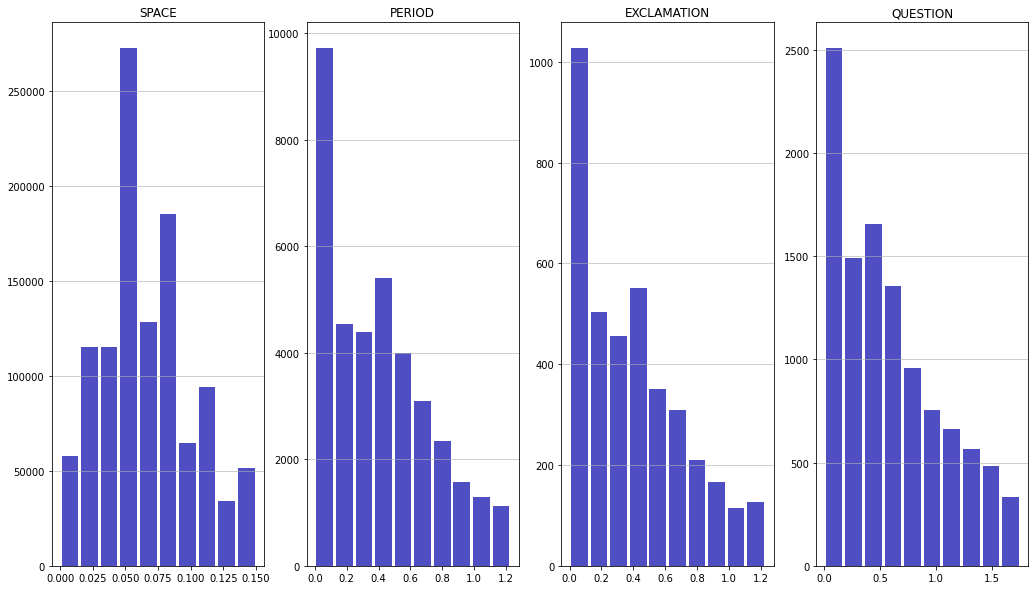

In [10]:
### Plot Histograms

fig, axs = plt.subplots(1, 4, figsize=(17.5, 10))

### Plot SPACE
indAxs = 0; indPunc = 0
n, bins, patches = axs[indAxs].hist(allCleanGaps[indPunc], bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
axs[indAxs].grid(axis='y', alpha=0.75)
axs[indAxs].set_title(namesPunc[indPunc])
### Plot PERIOD
indAxs = 1; indPunc = 2
n, bins, patches = axs[indAxs].hist(allCleanGaps[indPunc], bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
axs[indAxs].grid(axis='y', alpha=0.75)
axs[indAxs].set_title(namesPunc[indPunc])
### Plot EXCLAMATION
indAxs = 2; indPunc = 5
n, bins, patches = axs[indAxs].hist(allCleanGaps[indPunc], bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
axs[indAxs].grid(axis='y', alpha=0.75)
axs[indAxs].set_title(namesPunc[indPunc])
### Plot QUESTION
indAxs = 3; indPunc = 6
n, bins, patches = axs[indAxs].hist(allCleanGaps[indPunc], bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
axs[indAxs].grid(axis='y', alpha=0.75)
axs[indAxs].set_title(namesPunc[indPunc])

plt.show()